## 번외 Swipe 코인 가격 예측

21년 1월 1일 ~ 4월 14일 데이터를 통해 이 후 10일 간 금액 예측

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
swipe = pd.read_csv('/content/drive/MyDrive/Daycon/Swipe 과거 데이터.csv')

In [ ]:
swipe.head()

,날짜,종가,오픈,고가,저가,거래량,변동 %
0,2021년 04월 28일,3.83,4.13,4.13,3.83,1.89M,-6.92%
1,2021년 04월 27일,4.12,3.62,4.12,3.62,1.40M,13.51%
2,2021년 04월 26일,3.63,2.94,3.63,2.94,1.70M,23.86%
3,2021년 04월 25일,2.93,3.02,3.21,2.93,1.47M,-2.80%
4,2021년 04월 24일,3.01,3.14,3.14,2.88,1.36M,-4.13%


In [ ]:
ts_df = pd.DataFrame()

ts_df['ds'] = swipe['날짜']
ts_df['y'] = swipe['종가']

In [ ]:
ts_df.head()

,ds,y
0,2021년 04월 28일,3.83
1,2021년 04월 27일,4.12
2,2021년 04월 26일,3.63
3,2021년 04월 25일,2.93
4,2021년 04월 24일,3.01


In [ ]:
import datetime

def date_change(x):
    year = x[0:4]
    month  = x[6:8]
    day  = x[10:12]
    yes = year+'-'+month+'-'+day
    
    return yes

ts_df['ds'] = ts_df['ds'].apply(lambda x : datetime.datetime.strptime(date_change(x),"%Y-%m-%d"))

In [ ]:
ts_df = ts_df.set_index(ts_df['ds'])
ts_df.index.names = ['Date']

In [ ]:
ts_df.head()

,ds,y
Date,,
2021-04-28,2021-04-28,3.83
2021-04-27,2021-04-27,4.12
2021-04-26,2021-04-26,3.63
2021-04-25,2021-04-25,2.93
2021-04-24,2021-04-24,3.01


In [ ]:
len(ts_df)

484

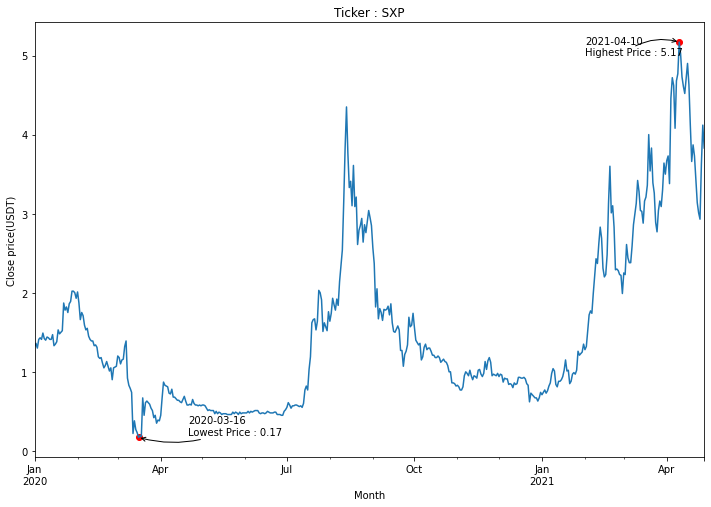

In [ ]:
# 가격 추세 확인
ax = ts_df['y'].plot(title = 'Ticker : SXP',figsize = (12,8))
ax.set_ylabel('Close price(USDT)')
ax.set_xlabel('Month')
ax.annotate("2021-04-10\nHighest Price : 5.17", xy = ("2021-04-10",5.17), xytext = ("2021-02-01",5),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2"))
ax.annotate("2020-03-16\nLowest Price : 0.17", xy = ("2020-03-16",0.17), xytext = ("2020-04-21",0.2),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2"))
ax.scatter("2021-04-10",5.17 , c='r')
ax.scatter("2020-03-16",0.17, c = 'r')
plt.show()

In [ ]:
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 484 entries, 2021-04-28 to 2020-01-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      484 non-null    datetime64[ns]
 1   y       484 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.3 KB


## Model1. Prophet

In [ ]:
train_df = ts_df[10:]

In [ ]:
train_df = train_df.reindex(train_df.index.sort_values(ascending = True))

In [ ]:
test_df = ts_df[:10]
test_df.head(10)

,ds,y
Date,,
2021-04-28,2021-04-28,3.83
2021-04-27,2021-04-27,4.12
2021-04-26,2021-04-26,3.63
2021-04-25,2021-04-25,2.93
2021-04-24,2021-04-24,3.01
2021-04-23,2021-04-23,3.14
2021-04-22,2021-04-22,3.43
2021-04-21,2021-04-21,3.73
2021-04-20,2021-04-20,3.87


In [ ]:
from fbprophet import Prophet
m = Prophet(daily_seasonality=True,
            yearly_seasonality = False,
            weekly_seasonality = True,
            changepoint_prior_scale = 0.1,
            seasonality_mode = 'additive')
m.fit(train_df)

In [ ]:
future = m.make_future_dataframe(periods = 10, freq = 'D')
forecast = m.predict(future)
forecast_yhat = forecast[['ds','yhat']]

In [ ]:
# 예측값 원화 변환
def usdt_change(x) :
  won, result = 0, 0
  won =  x * 1117.60  
  # 0.13 : 현재 해외장 대비 한국장 증감 %
  result = won + (won * 0.13)
  return result

forecast_yhat['low_won'] = forecast_yhat['yhat'].apply(lambda x : usdt_change(x))

In [ ]:
# 예측값 원화 변환
def usdt_change(x) :
  won, result = 0, 0
  won =  x * 1117.60  
  # 0.13 : 현재 해외장 대비 한국장 증감 %
  result = won + (won * 0.15)
  return result

forecast_yhat['upper_won'] = forecast_yhat['yhat'].apply(lambda x : usdt_change(x))

In [ ]:
# 10일 간 예측 10일 간 예측
forecast_yhat.tail(10)

,ds,yhat,low_won,upper_won
474,2021-04-19,4.572082,5774.026882,5876.222048
475,2021-04-20,4.609939,5821.837079,5924.878443
476,2021-04-21,4.631007,5848.443749,5951.956027
477,2021-04-22,4.695866,5930.352765,6035.314761
478,2021-04-23,4.757339,6007.986547,6114.322592
479,2021-04-24,4.777775,6033.794614,6140.587439
480,2021-04-25,4.819014,6085.875468,6193.590078
481,2021-04-26,4.842070,6114.992297,6223.222249
482,2021-04-27,4.879928,6162.802493,6271.878644
483,2021-04-28,4.900996,6189.409163,6298.956228


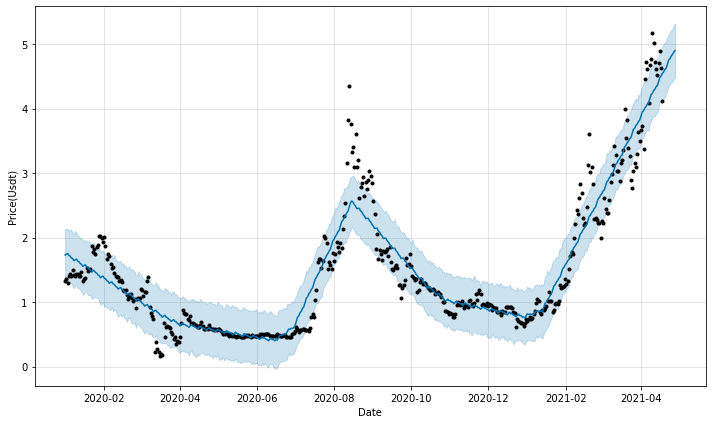

In [ ]:
fig1 = m.plot(forecast,xlabel = 'Date', ylabel = 'Price(Usdt)') 

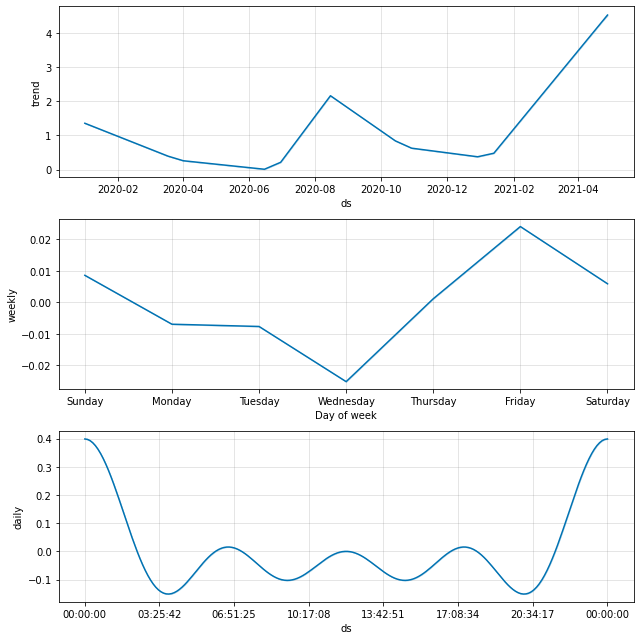

In [ ]:
# 계절성 파악
fig2 = m.plot_components(forecast)

In [ ]:
fore = forecast[['ds','yhat']][-10:]
pred_y = pd.merge(test_df,fore,on = 'ds')

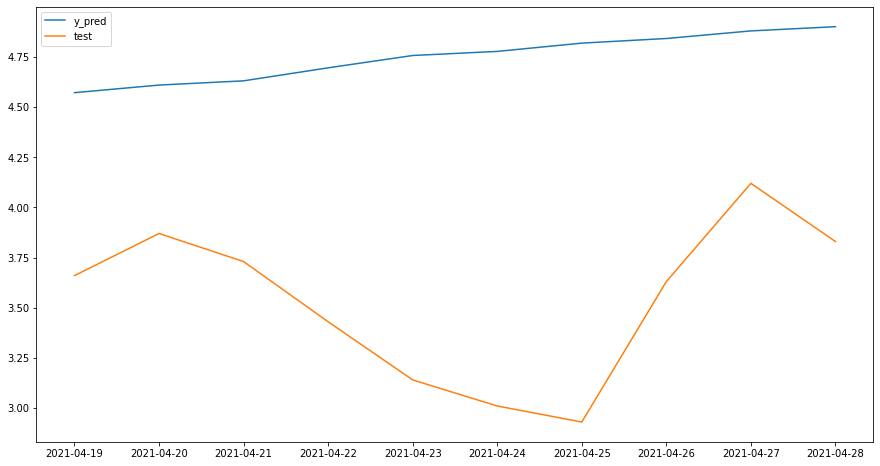

In [ ]:
plt.figure(figsize= (15,8))
plt.plot(pred_y['ds'],pred_y['yhat'], label = 'y_pred')
plt.plot(pred_y['ds'],pred_y['y'], label = 'test')
plt.legend()
plt.show()

In [ ]:
pd.merge(test_df,fore,on = 'ds')

,ds,y,yhat
0,2021-04-28,3.83,4.900996
1,2021-04-27,4.12,4.879928
2,2021-04-26,3.63,4.842070
3,2021-04-25,2.93,4.819014
4,2021-04-24,3.01,4.777775
5,2021-04-23,3.14,4.757339
6,2021-04-22,3.43,4.695866
7,2021-04-21,3.73,4.631007
8,2021-04-20,3.87,4.609939
9,2021-04-19,3.66,4.572082


## Model2. ARIMA 

AR : 자기 자신의 과거를 정보로 사용한다. "현재의 상태는 이전의 상태를 참고하여 계산된다"라는 의미를 기본 전제로 사용

MA : 이번 항에서의 오차를 이용하여 현재 항의 상태를 추론한다라는 형태의 방법이다.

ARIMA : ARMA에 추세 변동까지 반영한 방법이다.(비정상성을 제거하는 과정을 포함한 형)

AR(p) = ARIMA(p, 0, 0)<br>
MA(q) = ARIMA(0, 0, q)<br>
ARMA(p, q) = ARIMA(p, 0, q)


ARIMA의 모수는 p,d,q로 표현하며 p는 ar모형의 lag, d는 차분 횟수, q는 ma모형의 lag를 의미한다. 

통상적으로 p + q < 2나 p * q = 0인 값들을 모수로 사용한다.

In [ ]:
# ARIMA 호출
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

import statsmodels.api as sm

### acf, pacf

시계열 데이터가 ar 특성을 보이는 경우 acf는 천천히 하락하고 pacf는 급격히 감소한다.

시계열 데이터가 ma 특성을 보이는 경우 acf는 급격히 감소하고 pacf는 천천히 감소한다.

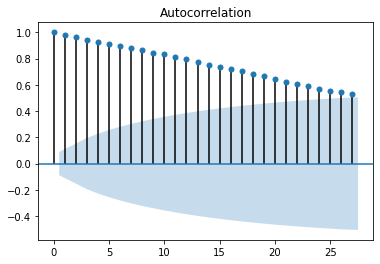

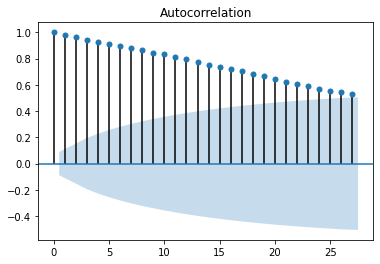

In [ ]:
# acf(자기상관 그래프) : lag에 따른 관측치들의 관련성을 관측하는 함수
# acf가 비정상 시계열이라 천천히 하락한다는게 보임
plot_acf(ts_df['y'])

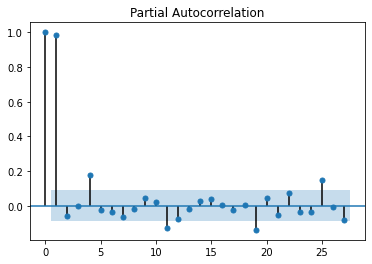

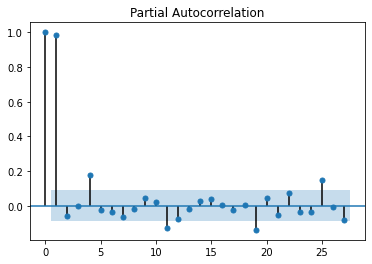

In [ ]:
# pacf : k이외의 다른 시점의 영향력은 배제하고 현재 시점과 특정 시점 두 관측치의 관련성을 관측하는 함수
plot_pacf(ts_df['y'])

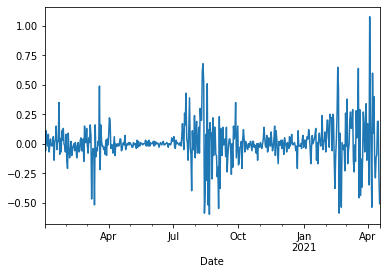

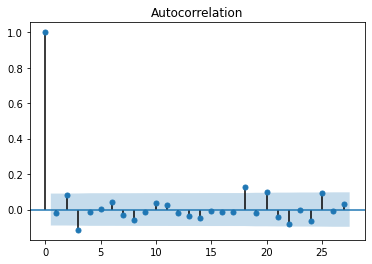

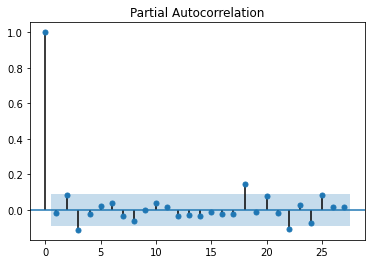

In [ ]:
# 1차 차분 진행
diff1 = train_df['y'].diff(periods = 1).iloc[1:]

# 그래프
diff1.plot()
plot_acf(diff1)
plot_pacf(diff1)
plt.show()

1차 차분 이후 acf가 잠잠해졌다.
pacf에서 절단점 1(q)


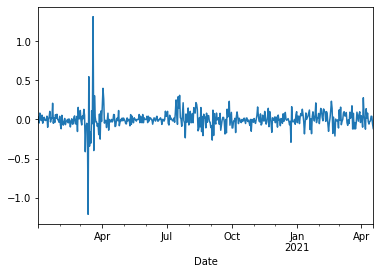

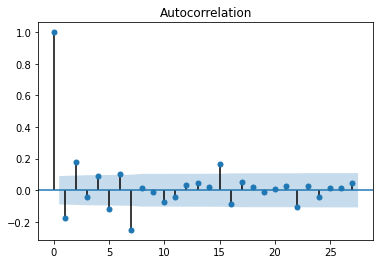

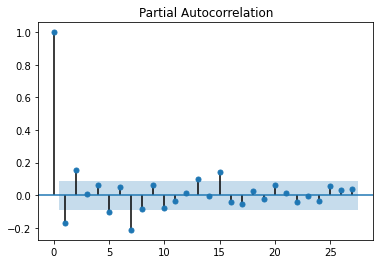

In [ ]:
diff1 = np.log(train_df['y']).diff(periods = 1).iloc[1:]

# 그래프
diff1.plot()
plot_acf(diff1)
plot_pacf(diff1)
plt.show()

변동 폭은 줄었지만 acf와 pacf의 신뢰구간을 벗어난 점들이 더 늘어났다.

In [ ]:
# ar = 3, 차분(d) = 1차인 ARIMA모델 적용
model = ARIMA(train_df.y.values, order = (3,1,0))
model_fit = model.fit(trend = 'c', full_output = True, disp = 1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  473
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 167.107
Method:                       css-mle   S.D. of innovations              0.170
Date:                Thu, 20 May 2021   AIC                           -324.214
Time:                        09:16:18   BIC                           -303.419
Sample:                             1   HQIC                          -316.035
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.008      0.786      0.432      -0.009       0.021
ar.L1.D.y     -0.0058      0.046     -0.126      0.900      -0.096       0.085
ar.L2.D.y      0.0814      0.046      1.768      0.0

모델 적용 결과 const는 0.518로 기각
AR(3)은 0.007로 유효하게 나왔다.

In [ ]:
# ar = 3, 차분(d) = 1차인 ARIMA모델 적용(트렌드 제거)
model = ARIMA(train_df.y.values, order = (2,1,0))
model_fit = model.fit(trend = 'nc', full_output = True, disp = True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  473
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 163.803
Method:                       css-mle   S.D. of innovations              0.171
Date:                Thu, 20 May 2021   AIC                           -321.606
Time:                        09:16:18   BIC                           -309.128
Sample:                             1   HQIC                          -316.698
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y     -0.0149      0.046     -0.323      0.747      -0.105       0.076
ar.L2.D.y      0.0854      0.046      1.845      0.066      -0.005       0.176
                                    Roots           

<Figure size 1152x720 with 0 Axes>

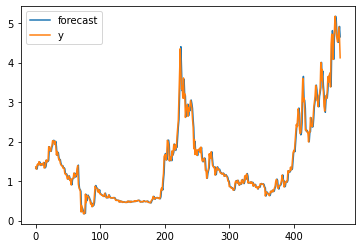

In [ ]:
fig = plt.figure(figsize=(16,10))
fig = model_fit.plot_predict()
plt.show()

In [ ]:
fore = model_fit.forecast(steps = 10)
print(fore)

(array([4.1045439 , 4.06122161, 4.06054738, 4.05685782, 4.05685524,
       4.0565402 , 4.05654467, 4.0565177 , 4.05651848, 4.05651617]), array([0.17114221, 0.24023475, 0.30214451, 0.35314331, 0.3982343 ,
       0.43869158, 0.47576244, 0.51014424, 0.54235397, 0.57275497]), array([[3.76911133, 4.43997646],
       [3.59037015, 4.53207306],
       [3.46835503, 4.65273974],
       [3.36470966, 4.74900599],
       [3.27633036, 4.83738011],
       [3.1967205 , 4.91635989],
       [3.12406742, 4.98902192],
       [3.05665337, 5.05638203],
       [2.99352424, 5.11951272],
       [2.93393706, 5.17909528]]))


In [ ]:
y_pred = fore[0].tolist()

In [ ]:
test_df['yhat'] = y_pred

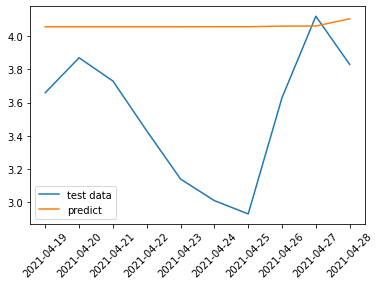

In [ ]:
plt.plot(test_df['y'], label = 'test data')
plt.plot(test_df['yhat'],label = 'predict')
plt.xticks(rotation = 45)
plt.legend()
plt.show()